In [2]:
# import packages
import os
import sys
import numpy as np
import pandas as pd
import pcntoolkit
import seaborn as sns
import pickle
import glob
import shutil
import matplotlib.pyplot as plt
import nilearn.plotting as plotting
from matplotlib.colors import ListedColormap

import xarray as xr
from glob import glob

# custom functions
code_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/code')
os.chdir(code_dir)
import clinics_desc_functions as custom


pk = sns.color_palette("RdBu_r", 20)

pk1 = pk[0:10]
pk1.reverse()
pk2 = pk[10:]
pk2.reverse()

ColdHot_r = ListedColormap([*pk1,*pk2])

/home/barbora/Instalacky/yes/envs/PCN/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [4]:
# Where things are
project_dir = ('/home/barbora/Documents/Projects/Normative_Models')
pretrained_dir = os.path.join(project_dir,'ESO', 'braincharts')
models_dir = os.path.join(project_dir,'ESO', 'models', 'pretrained_long_adapt_experiment', 'controls_adaptation')
data_dir = os.path.join(project_dir,'ESO', 'models', 'sensitivity', 'data')
images_dir = os.path.join(project_dir, 'ESO', 'models','diff_variance','img')
os.makedirs(images_dir, exist_ok=True)

In [5]:
# get basic parameters for pretrained models
model_name, site_names, site_ids_tr, idp_ids = custom.pretrained_ini()

In [238]:
# Pick the preprocessing and load data
preproc = 'long'

v1 = pd.read_csv(os.path.join(data_dir, 'all_'+preproc+'_thickness_1_qc.csv'), sep=' ', index_col=0)
v2 = pd.read_csv(os.path.join(data_dir, 'all_'+preproc+'_thickness_2_qc.csv'), sep=' ', index_col=0)

v1_pat = v1[v1['category']=='Patient']
v1_cont = v1[v1['category']=='Control']
v2_pat = v2[v2['category']=='Patient']
v2_cont = v2[v2['category']=='Control']

site_ids_te =  sorted(set(v1_pat['site'].to_list()))

Deviations computations
----------------------

**Compute ESO controls deviations**

In [7]:
# Load clinical data (needed to get indicies)
clin_conttest = pd.read_csv(os.path.join(models_dir, 'V1', 'v1_cont_test.txt'), sep=' ', index_col=0)

v1_y_conttest = pd.read_csv(custom.idp_concat(os.path.join(models_dir, 'V1'), 'y_conttest.txt', idp_ids, 'y_conttest_merge.txt'), sep=' ', index_col=0)
v1_y_conttest.index = clin_conttest.index

v2_y_conttest = pd.read_csv(custom.idp_concat(os.path.join(models_dir, 'V2'), 'y_conttest.txt', idp_ids, 'y_conttest_merge.txt'), sep=' ', index_col=0)
v2_y_conttest.index = clin_conttest.index

ESO_diff = v2_y_conttest[idp_ids] - v1_y_conttest[idp_ids]
ESO_diff = pd.concat([clin_conttest[['age','sex','site']], ESO_diff], axis = 1, join='inner')

**Load COINS deviations**

In [8]:
# Here load the variances from test-retest data - to compare the variances from our data
v1_coins = pd.read_csv(os.path.join(project_dir, 'COINS', 'models', 'threshold_50_y_included','CORR_V1_Y.csv'), sep=' ', index_col=0)
v2_coins = pd.read_csv(os.path.join(project_dir, 'COINS', 'models', 'threshold_50_y_included','CORR_V2_Y.csv'), sep=' ', index_col=0)
coins_diff = v2_coins[idp_ids]-v1_coins[idp_ids]
coins_diff = pd.concat([v1_coins[['age', 'sex', 'site']], coins_diff], axis = 1, join='inner')

**Concatenate and compare deviations on healthy controls across sites**

In [9]:
diff = pd.concat([coins_diff, ESO_diff], axis=0)

Text(0.5, 0.98, 'transformations Y2-Y1')

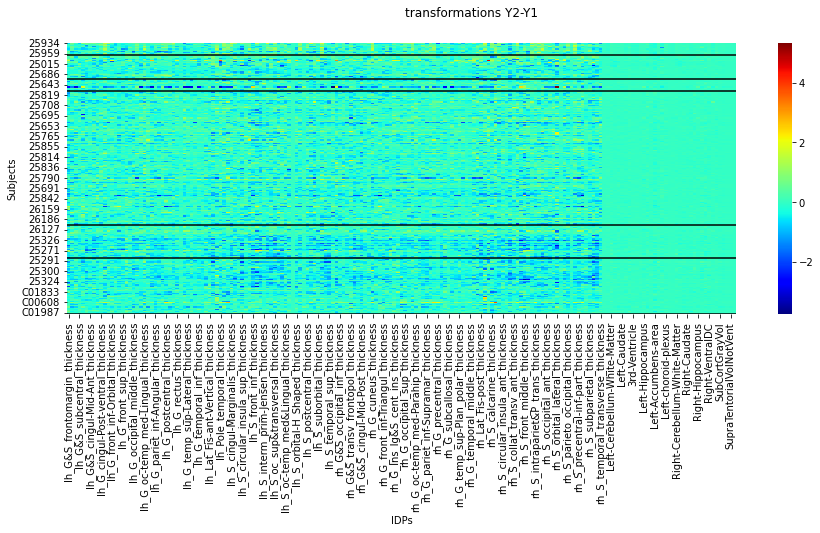

In [39]:
# Plotting (Y2-Yhat)-(Y1-Yhat) -> Y2-Y1 (order doesn't matter for variance)
#images_dir = os.path.join(models_dir, 'img')
no_sites = diff['site'].value_counts().sort_index().cumsum()

fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(diff[idp_ids], cmap='jet')
for isite in no_sites:
    ax.axhline(isite, color='black')
ax.set_xlabel('IDPs')
ax.set_ylabel('Subjects')
fig.suptitle('transformations Y2-Y1')
#plt.savefig(os.path.join(images_dir,'heatmap_Y2-Y1'))



<AxesSubplot:xlabel='site', ylabel='rh_G_parietal_sup_thickness'>

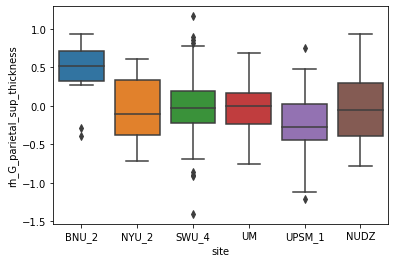

In [43]:
sns.boxplot(data = diff, y = idp_ids[100], x = 'site')

**HBR modelling site specific intercepts**
-------------------------------------------

**Alternative 1 -- only use variance of adaptation control data**

In [10]:
# Load Y, Yhat, S^2
udir = '/home/barbora/Documents/Projects/Normative_Models/ESO/models/pretrained_long_adapt_experiment/controls_adaptation'
v1_Y = pd.read_csv(custom.idp_concat(os.path.join(udir,'V1'), 'y_predict.txt', idp_ids, 'v1_y_test.txt'), sep=' ', index_col=0)
v1_Yhat = pd.read_csv(custom.idp_concat(os.path.join(udir,'V1'), 'yhat_predict.txt', idp_ids, 'v1_yhat_test.txt'), sep=' ', index_col=0)
v1_S2 = pd.read_csv(custom.idp_concat(os.path.join(udir,'V1'), 'ys2_predict.txt', idp_ids, 'v1_ys2_test.txt'), sep=' ', index_col=0)


v2_Y = pd.read_csv(custom.idp_concat(os.path.join(udir,'V2'), 'y_predict.txt',  idp_ids, 'v2_y_test.txt'), sep=' ', index_col=0)
v2_Yhat = pd.read_csv(custom.idp_concat(os.path.join(udir,'V2'), 'yhat_predict.txt',  idp_ids, 'v2_yhat_test.txt'), sep=' ', index_col=0)
v2_S2 = pd.read_csv(custom.idp_concat(os.path.join(udir,'V2'), 'ys2_predict.txt',  idp_ids, 'v2_ys2_test.txt'), sep=' ', index_col=0)



In [11]:
# prepare dataframe with variances across difference
diff_S2 = pd.DataFrame(ESO_diff[idp_ids].var())
diff_S2 = diff_S2.T
diff_S2 = diff_S2.append([diff_S2]*(v1_Y.shape[0]-1),ignore_index=True)
diff_S2.index = v1_Y.index

v1_Z = (v1_Y - v1_Yhat)/np.sqrt(v1_S2 + diff_S2)
v2_Z = (v2_Y - v2_Yhat)/np.sqrt(v2_S2 + diff_S2)

<AxesSubplot:>

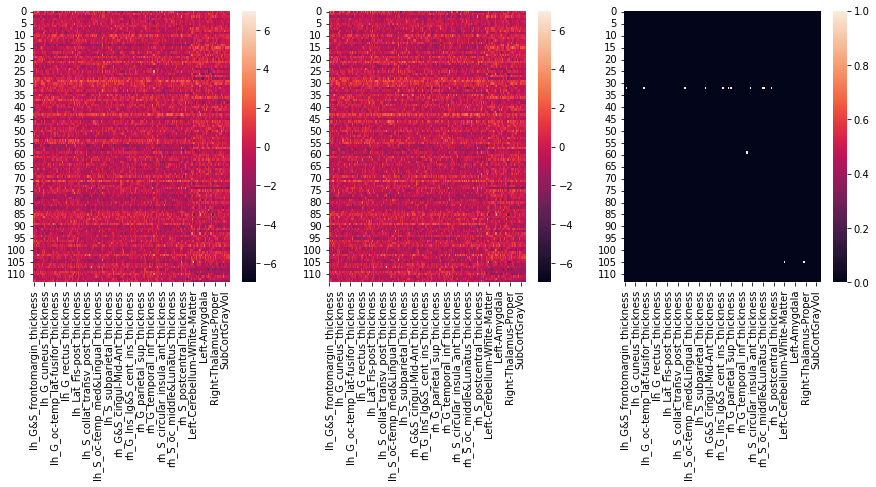

In [12]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
sns.heatmap(v1_Z, ax = ax[0], vmin = -7, vmax = 7)
sns.heatmap(v2_Z, ax = ax[1], vmin = -7, vmax = 7)
sns.heatmap((v2_Z-v1_Z)<-2, ax = ax[2])

In [13]:
# load Z values across all idps and all patients
v1_Z_orig = pd.read_csv(custom.idp_concat(os.path.join(udir,'V1'), 'Z_predict.txt', idp_ids, 'v1_z_orig_test.txt'), sep=' ', index_col=0)
v2_Z_orig = pd.read_csv(custom.idp_concat(os.path.join(udir,'V2'), 'Z_predict.txt',  idp_ids, 'v2_z_orig_test.txt'), sep=' ', index_col=0)

In [19]:
# Concatenate original and recomputed Z-values
pk_zorig = np.concatenate((v2_Z_orig-v1_Z_orig).to_numpy(), axis =0)
pk_z = np.concatenate((v2_Z-v1_Z).to_numpy(), axis =0)

z_compar = pd.concat([(v2_Z_orig-v1_Z_orig).stack(),(v2_Z-v1_Z).stack()], axis=1)
z_compar.columns=['orig', 'control_based_variance']

z_compar = pd.DataFrame(z_compar.stack(), columns = ['val'])
z_compar['idp'] = z_compar.index.get_level_values(1).astype('category')
z_compar['type'] = z_compar.index.get_level_values(2).astype('category')
z_compar['id'] = z_compar.index.get_level_values(0).astype('category')

In [15]:
# temporarily filter only 
data_type = 'control_based_variance' #'orig' / 'control_based_variance'
z_compar = z_compar[z_compar['type'] == data_type]

z_compar = z_compar.sort_values('val')
z_compar['order'] = range(0,z_compar.shape[0])

# Plot across areas

data_mapping, view, fs_plot, fs_sulc = custom.prepare_destrieux_plotting(pd.DataFrame(z_compar.groupby('idp').agg('median').sort_values('order')['val']),
                                                                        'r', method='correlations')

plotting.view_surf(fs_plot, data_mapping, threshold=None, cmap='jet', bg_map=fs_sulc, vmin=-0.2, vmax=0.2,
                    title=data_type+' PCN Z-score median of difference V2-V1 across IDPs').save_as_html(file_name=os.path.join(images_dir,data_type+'_Zscore_median_diff_rh.html'))

data_mapping, view, fs_plot, fs_sulc = custom.prepare_destrieux_plotting(pd.DataFrame(z_compar.groupby('idp').agg('median').sort_values('order')['val']),
                                                                        'l', method='correlations')

plotting.view_surf(fs_plot, data_mapping, threshold=None, cmap='jet', bg_map=fs_sulc, vmin=-0.2, vmax=0.2,
                    title=data_type+' PCN Z-score median of difference V2-V1 across IDPs').save_as_html(file_name=os.path.join(images_dir,data_type+'_Zscore_median_diff_lh.html'))


/home/barbora/Instalacky/yes/envs/PCN/lib/python3.9/site-packages/nilearn/plotting/js_plotting_utils.py:81: UserWarning: vmin cannot be chosen when cmap is symmetric
  warnings.warn('vmin cannot be chosen when cmap is symmetric')


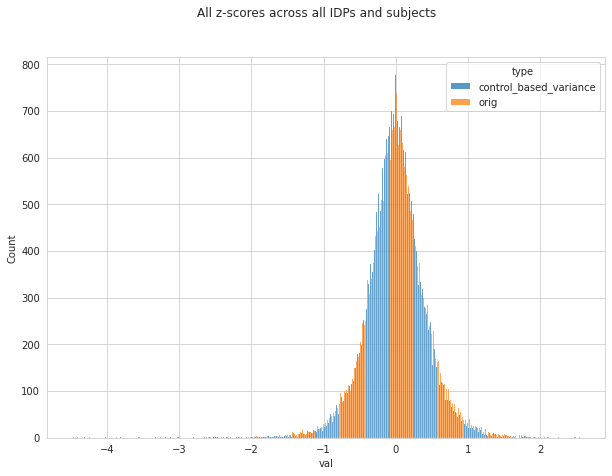

In [280]:
fig,ax = plt.subplots(figsize=(10,7))
sns.set_style('whitegrid')
sns.histplot(data = z_compar, x='val', hue='type', multiple='dodge')
fig.suptitle('All z-scores across all IDPs and subjects')
plt.savefig(os.path.join(images_dir, 'hist_zscores_all_IDP'))

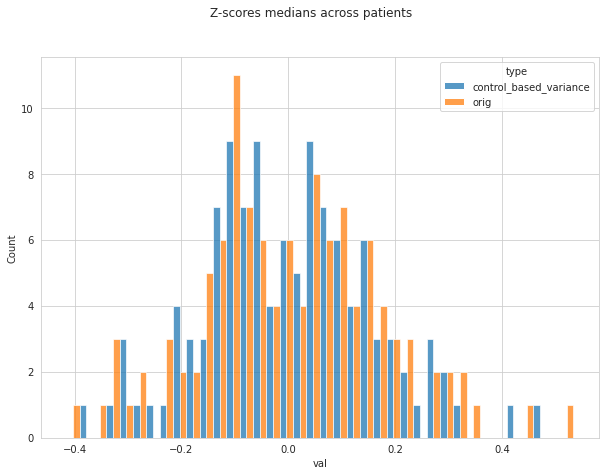

In [26]:
sns.set_style('whitegrid')
gb = z_compar.groupby(['id','type']).agg('median').sort_values('val')
gb['type'] = gb.index.get_level_values(1).astype('category')
fig, ax = plt.subplots(figsize = (10,7))
sns.histplot(data =gb, x ='val', hue='type', multiple='dodge', binwidth=0.025)
fig.suptitle('Z-scores medians across patients')
plt.savefig(os.path.join(images_dir, 'hist_median_zscore_patients'))

In [ ]:
# One trajectory image - horizontal
nplots = 16
nfigures = 0

fig,ax = plt.subplots(12,nplots, figsize=(60,40), sharex = True, sharey=True)


for i, idp in enumerate(idp_ids):
    
    x = int(np.floor(i/nplots))
    y = np.mod(i,nplots)
    sns.lineplot(data = gdata, x='visit', y = idp, hue='category', markers=True, style='category',dashes=False, ax = ax[x,y], linewidth=4)
    ax[x,y].set_ylabel('')
    #ax[x,y]._legend.remove()
    ax[x,y].legend([],[],frameon=False)
    #ax[x,y].set_title(idp)

fig.suptitle('Average trajectories '+preproc_type+' '+data_type)
sns.despine
#plt.savefig(os.path.join(images_dir,'average_trajectories_'+data_type+'_'+preproc_type+'_horizontal'))

In [37]:
to_plot = pd.concat([v1_Z.mean(), v2_Z.mean()], axis=1)
to_plot.columns = ['v1', 'v2']
to_plot = pd.DataFrame(to_plot.stack(), columns=['val'])
to_plot['idp']=to_plot.index.get_level_values(0).astype('category')
to_plot['visit']=to_plot.index.get_level_values(1).astype('category')

In [79]:
diff = v2_Z - v1_Z

for i, idp in enumerate(idp_ids):
    temp = pd.DataFrame(diff[idp]).sort_values(idp)
    temp[idp+'_order'] = range(0,temp.shape[0])
    diff = pd.concat([diff, temp[idp+'_order']], axis=1, join='inner')

In [81]:
order = [i for i in diff.columns if 'order' in i]

<AxesSubplot:>

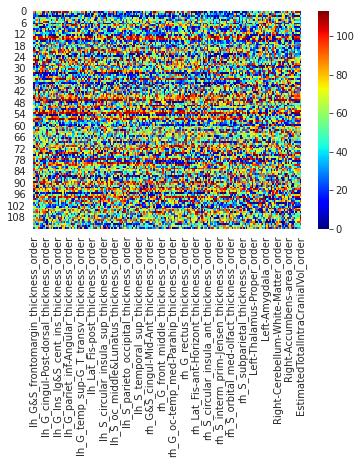

In [86]:
sns.heatmap(diff[order], cmap ='jet')

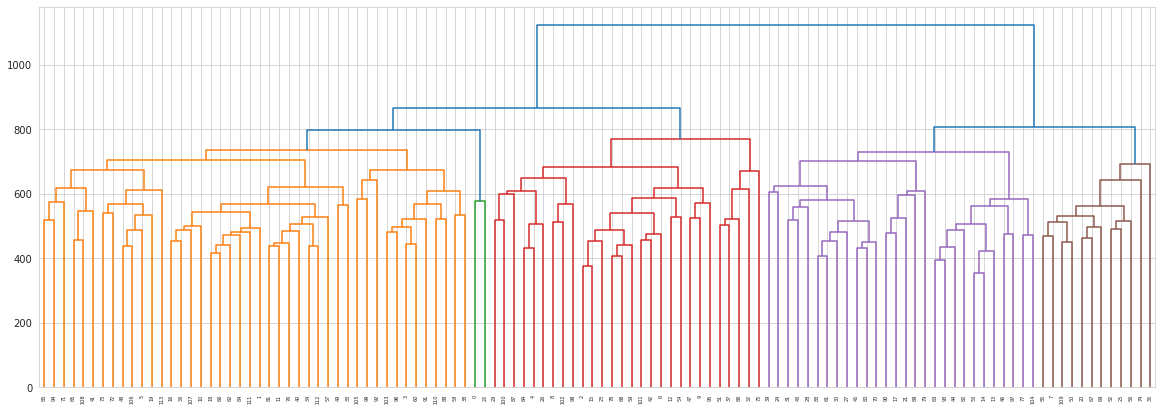

In [118]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib import pyplot as plt

linked = linkage(diff[order], 'complete', optimal_ordering=True)

labelList = range(0, diff.shape[0])

plt.figure(figsize=(20, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

cluster = fcluster(linkage(diff[order], 'complete', optimal_ordering=True),790,'distance')
diff['cluster'] =cluster

In [196]:
diff[[*idp_ids,'cluster']].groupby('cluster').agg('median').max().max()
counts = diff['cluster'].value_counts().sort_index()

In [198]:
counts

1    12
2    28
3    28
4    44
5     2
Name: cluster, dtype: int64

In [154]:
diff.index = pd.MultiIndex.from_frame(pd.DataFrame([range(0,diff.shape[0]),diff['cluster']]).T, names=['id', 'cluster'])
diff_long = pd.DataFrame(diff[idp_ids].stack(), columns=['val'])
#diff_long['id'] = diff_long.index.get_level_values(0).astype('category')
diff_long['cluster'] = diff_long.index.get_level_values(1).astype('category')
diff_long['idp'] = diff_long.index.get_level_values(2).astype('category')

<AxesSubplot:xlabel='val', ylabel='idp'>

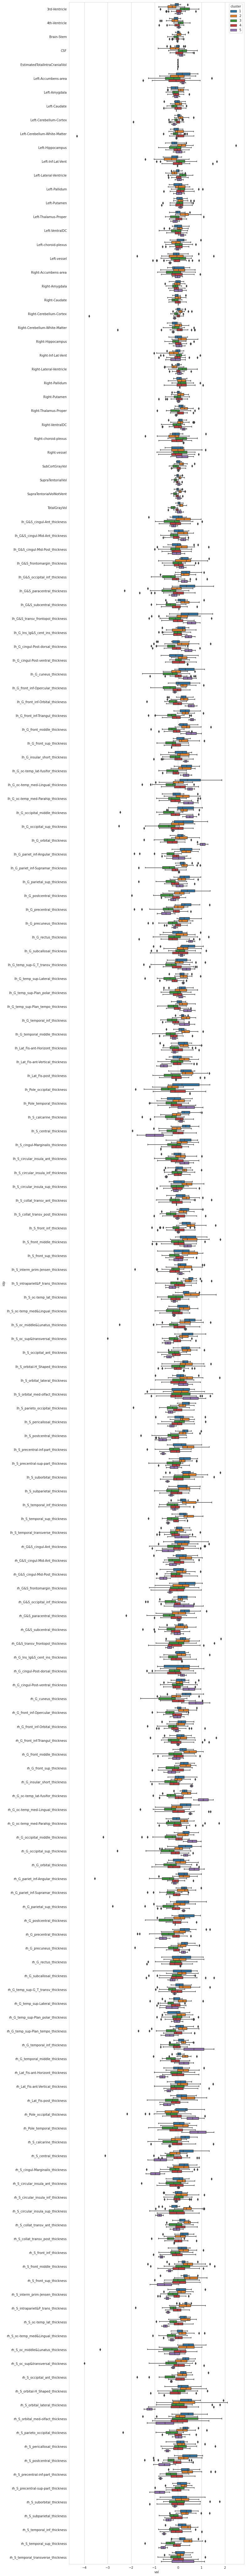

In [167]:
# plot boxplots across clusters
fig,ax = plt.subplots(figsize=(10,150))
sns.boxplot(data=diff_long, x='val', y='idp', hue = 'cluster', orient='h')

In [185]:
diff.index = diff.index.get_level_values(0).astype('category')

In [199]:
# surface plots of individual clusters
# Plot across areas
counts = diff['cluster'].value_counts().sort_index()

for icluster in range(1,6):
    data_mapping, view, fs_plot, fs_sulc = custom.prepare_destrieux_plotting(pd.DataFrame(diff[diff['cluster'] == icluster][idp_ids].agg('median'), columns=['val']),
                                                                            'r', method='correlations')

    plotting.view_surf(fs_plot, data_mapping, threshold=None, cmap='jet', bg_map=fs_sulc, vmin=-1, vmax=1,
                        title='cluster_'+str(icluster)+' median of difference V2-V1 across IDPs (n = '+str(counts[icluster])+')').save_as_html(file_name=os.path.join(images_dir,'cluster_'+str(icluster)+'_Zscore_median_diff_rh.html'))

    data_mapping, view, fs_plot, fs_sulc = custom.prepare_destrieux_plotting(pd.DataFrame(diff[diff['cluster'] == icluster][idp_ids].agg('median'), columns=['val']),
                                                                            'l', method='correlations')

    plotting.view_surf(fs_plot, data_mapping, threshold=None, cmap='jet', bg_map=fs_sulc, vmin=-1, vmax=1,
                        title='cluster_'+str(icluster)+' median of difference V2-V1 across IDPs (n = '+str(counts[icluster])+')').save_as_html(file_name=os.path.join(images_dir,'cluster_'+str(icluster)+'_Zscore_median_diff_lh.html'))


/home/barbora/Instalacky/yes/envs/PCN/lib/python3.9/site-packages/nilearn/plotting/js_plotting_utils.py:81: UserWarning: vmin cannot be chosen when cmap is symmetric
  warnings.warn('vmin cannot be chosen when cmap is symmetric')


<AxesSubplot:ylabel='Count'>

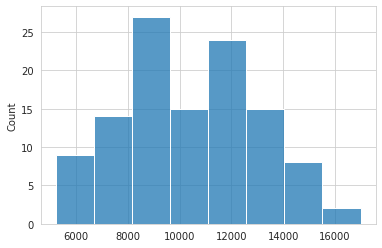

In [90]:
sns.histplot(diff[order].sum(axis=1))

In [203]:
diff.index = v1_pat.index

In [257]:
clin_id = ['PANSS_sumP', 'PANSS_sumN', 'PANSS_sumG', 'PANSS_∑', 'GAF']
clin_diff = v2_pat[clin_id] - v1_pat[clin_id]
clin_diff = pd.DataFrame(custom.control_for(clin_diff.to_numpy(), v1_pat['age'].to_numpy()[:,np.newaxis]), columns=clin_id, index=v1_pat.index)

In [268]:
cdiff = pd.concat([diff, clin_diff], axis=1, join='inner')

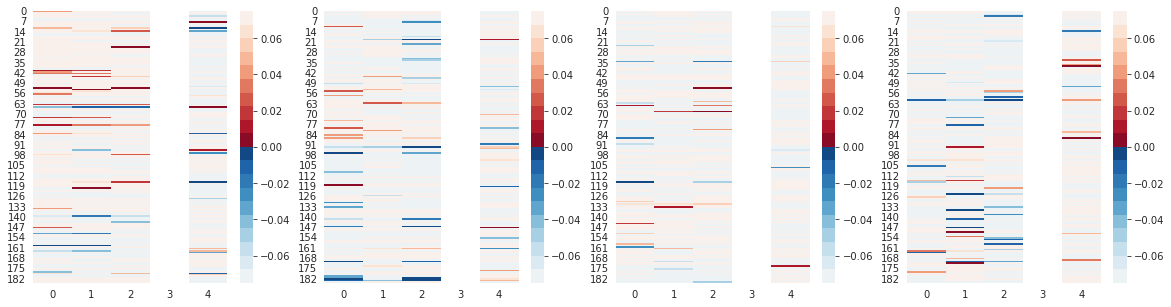

In [269]:
# Heatmaps of correlation of groups with clinics
fig,ax = plt.subplots(1,4,figsize=(20,5))
for i in range(1,5):
    sns.heatmap(custom.spearman_matrices(cdiff[cdiff['cluster']==i][idp_ids], cdiff[cdiff['cluster']==i][clin_id])[2], cmap=ColdHot_r, ax=ax[i-1], vmin=-0.075, vmax=0.075)


In [255]:
counts

1    12
2    28
3    28
4    44
5     2
Name: cluster, dtype: int64

In [273]:
clin_diff

,PANSS_sumP,PANSS_sumN,PANSS_sumG,PANSS_∑,GAF
P00565,1.686582,-2.087722,4.277172,NaN,9.916939
P00566,-3.128655,5.535196,2.485776,NaN,-0.104469
P00574,6.493397,2.293503,6.738237,NaN,5.902360
P00589,5.058791,5.159107,5.360565,NaN,0.892143
P00642,1.740587,9.797545,5.573119,NaN,-10.102107
...,...,...,...,...,...
P02637,3.899895,3.484292,20.134684,NaN,-5.086915
P02640,-6.956041,-0.804756,-9.961548,NaN,14.910481
P02647,-1.291693,-7.131310,-0.737340,NaN,4.916547
P02661,2.822771,3.639032,-3.813799,NaN,-0.085522
